# Finite-state model experiment using numpy and TensorFlow

Author: Simo Särkkä

This experiment is about solving the optimal control problem in a game where some flying device moves
in a cave from left to right with a constant speed and tries to avoid rough terrain by taking control actions up,
right, or no action.

The first part of the demo is written in pure numpy, but the second part needs TensorFlow.

## Imports

In [1]:
import numpy as np
import parallel_control.fsc_np as fsc_np
import math
import parallel_control.finite_model_np as finite_model_np
import matplotlib.pyplot as plt

## Generate and plot the game data; apply sequential FSC


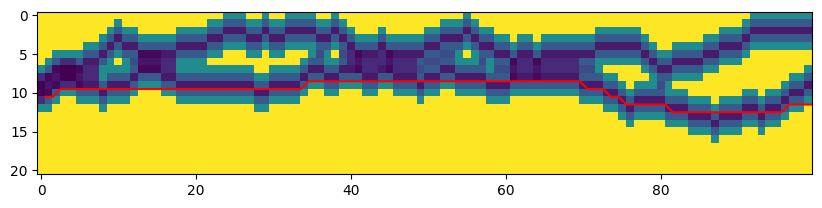

In [2]:
T = 100
model = finite_model_np.FiniteModel()
track, x0 = model.genData(T, nx=21)

fsc = model.getFSC(track)
u_list_seq, V_list_seq = fsc.seqBackwardPass()
min_cost_seq = V_list_seq[0][x0]
min_u_seq, min_x_seq = fsc.seqForwardPass(x0,u_list_seq)

steps = np.array(range(T))

plt.figure(figsize=(10,8))
plt.imshow(track)
plt.plot(steps + 0.5, np.array(min_x_seq[0:-1]) + 0.5, color='r')
plt.show()

np.savetxt('res/fsc_track.txt',track)
np.savetxt('res/fsc_min_x_seq.txt',np.array(min_x_seq[0:-1]))

## Check that the parallel versions give the same results


In [3]:
u_list_par, V_list_par = fsc.parBackwardPass()
min_u_par1, min_x_par1 = fsc.parForwardPass(x0,u_list_par)
min_cost_par = V_list_par[0][x0]
min_u_par2, min_x_par2 = fsc.parFwdBwdPass(x0,u_list_par,V_list_par)

print("min_cost_seq = %.6f" % min_cost_seq)
print("min_cost_par = %.6f" % min_cost_par)

print("pFSC1 dx = %g" % np.max(np.abs(np.array(min_x_par1) - np.array(min_x_seq))))
print("pFSC1 du = %g" % np.max(np.abs(np.array(min_u_par1) - np.array(min_u_seq))))
print("pFSC2 dx = %g" % np.max(np.abs(np.array(min_x_par2) - np.array(min_x_seq))))
print("pFSC2 du = %g" % np.max(np.abs(np.array(min_u_par2) - np.array(min_u_seq))))

min_cost_seq = 24.580000
min_cost_par = 24.580000
pFSC1 dx = 0
pFSC1 du = 0
pFSC2 dx = 0
pFSC2 du = 0


## Imports for the TensorFlow version

In [4]:
import tensorflow as tf
import parallel_control.fsc_tf as fsc_tf

2023-02-02 18:17:36.403002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Run and check that the results match

In [5]:
tf_min_x_seq = tf.convert_to_tensor(min_x_seq, dtype=tf.int32)
tf_min_u_seq = tf.convert_to_tensor(min_u_seq, dtype=tf.int32)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

with tf.device('/GPU:0'):
    fs, Ls, LT = fsc_tf.fsc_np_to_tf(fsc, dtype=tf.float64)
    us, Vs = fsc_tf.fsc_seq_backwardpass(fs, Ls, LT)
    min_xs_tf_seq, min_us_tf_seq = fsc_tf.fsc_seq_forwardpass(tf.constant(x0, dtype=fs.dtype), fs, us)
    min_cost_tf_seq = Vs[0,x0]

print("min_cost_seq = %.6f" % min_cost_seq)
print("min_cost_tf_seq = %.6f" % min_cost_tf_seq)

print("TF-FSC dx = %g" % tf.reduce_max(tf.abs(min_xs_tf_seq - tf_min_x_seq)))
print("TF-FSC du = %g" % tf.reduce_max(tf.abs(min_us_tf_seq - tf_min_u_seq)))

with tf.device('/GPU:0'):
    print(fs.shape)
    print(Ls.shape)
    print(LT.shape)
    us, Vs = fsc_tf.fsc_par_backwardpass(fs, Ls, LT)
    min_us_tf_par1, min_xs_tf_par1 = fsc_tf.fsc_par_forwardpass(x0, fs, us)
    min_cost_tf_par = Vs[0,x0]
    min_us_tf_par2, min_xs_tf_par2 = fsc_tf.fsc_par_fwdbwdpass(x0, fs, Ls, us, Vs)

print("TF-pFSC1 dx = %g" % tf.reduce_max(tf.abs(min_xs_tf_par1 - tf_min_x_seq)))
print("TF-pFSC1 du = %g" % tf.reduce_max(tf.abs(min_us_tf_par1 - tf_min_u_seq)))
print("TF-pFSC2 dx = %g" % tf.reduce_max(tf.abs(min_xs_tf_par2 - tf_min_x_seq)))
print("TF-pFSC2 du = %g" % tf.reduce_max(tf.abs(min_us_tf_par2 - tf_min_u_seq)))



Num GPUs Available:  0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
min_cost_seq = 24.580000
min_cost_tf_seq = 24.580000
TF-FSC dx = 0
TF-FSC du = 0
(100, 21, 3)
(100, 21, 3)
(21,)
TF-pFSC1 dx = 0
TF-pFSC1 du = 0
TF-pFSC2 dx = 0
TF-pFSC2 du = 0
